<!-- <p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Logo-gustave-roussy.jpg/1200px-Logo-gustave-roussy.jpg" alt="Logo 1" width="250"/>
  <img src="https://upload.wikimedia.org/wikipedia/en/thumb/3/3f/Qube_Research_%26_Technologies_Logo.svg/1200px-Qube_Research_%26_Technologies_Logo.svg.png" alt="Logo 2" width="200" style="margin-left: 20px;"/>
</p> -->

# Data Challenge : Leukemia Risk Prediction


*GOAL OF THE CHALLENGE and WHY IT IS IMPORTANT:*

The goal of the challenge is to **predict disease risk for patients with blood cancer**, in the context of specific subtypes of adult myeloid leukemias.

The risk is measured through the **overall survival** of patients, i.e. the duration of survival from the diagnosis of the blood cancer to the time of death or last follow-up.

Estimating the prognosis of patients is critical for an optimal clinical management. 
For exemple, patients with low risk-disease will be offered supportive care to improve blood counts and quality of life, while patients with high-risk disease will be considered for hematopoietic stem cell transplantion.

The performance metric used in the challenge is the **IPCW-C-Index**.

*THE DATASETS*

The **training set is made of 3,323 patients**.

The **test set is made of 1,193 patients**.

For each patient, you have acces to CLINICAL data and MOLECULAR data.

The details of the data are as follows:

- OUTCOME:
  * OS_YEARS = Overall survival time in years
  * OS_STATUS = 1 (death) , 0 (alive at the last follow-up)

- CLINICAL DATA, with one line per patient:
  
  * ID = unique identifier per patient
  * CENTER = clinical center
  * BM_BLAST = Bone marrow blasts in % (blasts are abnormal blood cells)
  * WBC = White Blood Cell count in Giga/L 
  * ANC = Absolute Neutrophil count in Giga/L
  * MONOCYTES = Monocyte count in Giga/L
  * HB = Hemoglobin in g/dL
  * PLT = Platelets coutn in Giga/L
  * CYTOGENETICS = A description of the karyotype observed in the blood cells of the patients, measured by a cytogeneticist. Cytogenetics is the science of chromosomes. A karyotype is performed from the blood tumoral cells. The convention for notation is ISCN (https://en.wikipedia.org/wiki/International_System_for_Human_Cytogenomic_Nomenclature). Cytogenetic notation are: https://en.wikipedia.org/wiki/Cytogenetic_notation. Note that a karyotype can be normal or abnornal. The notation 46,XX denotes a normal karyotype in females (23 pairs of chromosomes including 2 chromosomes X) and 46,XY in males (23 pairs of chromosomes inclusing 1 chromosme X and 1 chromsome Y). A common abnormality in the blood cancerous cells might be for exemple a loss of chromosome 7 (monosomy 7, or -7), which is typically asssociated with higher risk disease

In [ ]:
## TODO side note : mesures sont dans des échelles différentes donc attention à normaliser et standardiser les données

- GENE MOLECULAR DATA, with one line per patient per somatic mutation. Mutations are detected from the sequencing of the blood tumoral cells. 
We call somatic (= acquired) mutations the mutations that are found in the tumoral cells but not in other cells of the body.

  * ID = unique identifier per patient
  * CHR START END = position of the mutation on the human genome
  * REF ALT = reference and alternate (=mutant) nucleotide
  * GENE = the affected gene
  * PROTEIN_CHANGE = the consequence of the mutation on the protei that is expressed by a given gene
  * EFFECT = a broad categorization of the mutation consequences on a given gene.
  * VAF = Variant Allele Fraction = it represents the **proportion** of cells with the deleterious mutations. 

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored , concordance_index_ipcw
from sklearn.impute import SimpleImputer
from sksurv.util import Surv

import os
import re

In [2]:
# Files in the directory
# print(os.listdir("."))

# Clinical Data
# TODO : adapting to my local path
df = pd.read_csv("../data/X_train/clinical_train.csv")
df_eval = pd.read_csv("../data/X_test/clinical_test.csv")

# Molecular Data
maf_df = pd.read_csv("../data/X_train/molecular_train.csv")
maf_eval = pd.read_csv("../data/X_test/molecular_test.csv")

target_df = pd.read_csv("../data/target_train.csv")
# TODO: sera fourni le 15 ou le 17 mars
# target_df_test = pd.read_csv("./target_test.csv")

# Preview the data
df.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx"
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


### Step 1: Data Preparation (clinical data only)

For survival analysis, we’ll format the dataset so that OS_YEARS represents the time variable and OS_STATUS represents the event indicator.

In [3]:
### (sort of) Data Cleaning and Preprocessing

# Drop rows where 'OS_YEARS' is NaN if conversion caused any issues
# initial shape
# print(target_df.shape)
# drop rows with missing values
target_df.dropna(subset=['OS_YEARS', 'OS_STATUS'], inplace=True)
# final shape
# print(target_df.shape)
# percentage of rows dropped:
print(f'Percentage of initially dropt rows {(1 - target_df.shape[0] / df.shape[0]) * 100:.2f}%')

# Check the data types to ensure 'OS_STATUS' is boolean and 'OS_YEARS' is numeric
print(target_df[['OS_STATUS', 'OS_YEARS']].dtypes)

# Contarget_dfvert 'OS_YEARS' to numeric if it isn’t already
target_df['OS_YEARS'] = pd.to_numeric(target_df['OS_YEARS'], errors='coerce')

# Ensure 'OS_STATUS' is boolean
target_df['OS_STATUS'] = target_df['OS_STATUS'].astype(bool)

Percentage of initially dropt rows 4.51%
OS_STATUS    float64
OS_YEARS     float64
dtype: object


In [4]:
### Feature Selection :

# Zero : features they selected for the Benchmark model :
features_basic = ['BM_BLAST', 'HB', 'PLT']
# Accuracies for each implemented model :
# Benchmark LigthGBM: 
# Benchmark CoxPH:
# Benchmark RandomSurvivalForest:
# Benchmark when adding the Nmut count as a feature :


# First: Naively add all the features  (except the Gene column):
# features= ['BM_BLAST', 'HB', 'PLT', 'WBC', 'ANC', 'MONOCYTES']
# Very naive : slight improvement

# Second : construct some features based on scientific knowledge, and add them to the dataframe and the features list
df['BLAST_per_WBC'] = df['BM_BLAST'] / df['WBC']
df['ANC_per_WBC'] = df['ANC'] / df['WBC']
# df['MONOCYTES_per_WBC'] = df['MONOCYTES'] / df['WBC']           # too much missing values, first drop it, then see how to exploit it
df["PL_per_HB"] = df['PLT'] / df['HB']
# add these features to the features list
features_additional = ['BLAST_per_WBC', 'ANC_per_WBC', 'PL_per_HB']

df.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS,BLAST_per_WBC,ANC_per_WBC,PL_per_HB
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]",5.000000,0.071429,15.657895
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx",0.135135,0.324324,3.620690
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]",4.054054,0.567568,5.704225
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]",0.256410,0.487179,8.651685
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]",0.046875,0.075781,17.567568


In [5]:
# la meme pour le df_eval
df_eval['BLAST_per_WBC'] = df_eval['BM_BLAST'] / df_eval['WBC']
df_eval['ANC_per_WBC'] = df_eval['ANC'] / df_eval['WBC']
df_eval["PL_per_HB"] = df_eval['PLT'] / df_eval['HB']

In [6]:
df_eval.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS,BLAST_per_WBC,ANC_per_WBC,PL_per_HB
0,KYW1,KYW,68.0,3.45,0.5865,NaN,7.6,48.0,"47,XY,+X,del(9)(q?)[15]/47,XY,+X[5]",19.710145,0.17,6.315789
1,KYW2,KYW,35.0,3.18,1.2402,NaN,10.0,32.0,"46,XY,der(3)?t(3;11)(q26.2;q23),add(4)(p15).de...",11.006289,0.39,3.200000
2,KYW3,KYW,NaN,12.40,8.6800,NaN,12.3,25.0,"47,XX,+8",NaN,0.70,2.032520
3,KYW4,KYW,61.0,5.55,2.0535,NaN,8.0,44.0,Normal,10.990991,0.37,5.500000
4,KYW5,KYW,2.0,1.21,0.7381,NaN,8.6,27.0,"43,XY,dic(5;17)(q11.2;p11.2),-7,-13,-20,-22,+r...",1.652893,0.61,3.139535


In [7]:
# Third approach - exploiter les données cytogénétiques
import re
high_risk_patterns = [r"-7", r"-5", r"-17", r"del\(5\)", r"del\(17\)", r"del\(20\)", r"del\(9\)",
                      r"\+8", r"t\(3;3\)", r"complex", r"t\(9;11\)", r"i\(17\)"]

def categorize_cytogenetics(cytogenetics):
    if pd.isna(cytogenetics) or cytogenetics.strip() == "":
        return "Unknown"
    cytogenetics = cytogenetics.upper()
    for pattern in high_risk_patterns:
        if re.search(pattern, cytogenetics):
            return "High_Risk"
    return "Low_Intermediate"

# TODO : faire plus de catégories


In [8]:
df["CYTO_RISK"] = df["CYTOGENETICS"].apply(categorize_cytogenetics)
df = pd.get_dummies(df, columns=["CYTO_RISK"])
# drop the "Unknown" column
# est ce que ça suffit de garder la "High risk column" ?
df.drop(columns=["CYTO_RISK_Unknown"], inplace=True)
df.drop(columns=["CYTO_RISK_Low_Intermediate"], inplace=True)

In [9]:
features_cytogenetics = ['CYTO_RISK_High_Risk']
df.drop(columns=["CYTOGENETICS"], inplace=True)
df.head()
# df.shape

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,BLAST_per_WBC,ANC_per_WBC,PL_per_HB,CYTO_RISK_High_Risk
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,5.000000,0.071429,15.657895,False
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,0.135135,0.324324,3.620690,False
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,4.054054,0.567568,5.704225,False
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,0.256410,0.487179,8.651685,False
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,0.046875,0.075781,17.567568,False


In [10]:
# meme transformation pour le df_eval
df_eval["CYTO_RISK"] = df_eval["CYTOGENETICS"].apply(categorize_cytogenetics)
df_eval = pd.get_dummies(df_eval, columns=["CYTO_RISK"])
df_eval.drop(columns=["CYTO_RISK_Unknown"], inplace=True)
df_eval.drop(columns=["CYTO_RISK_Low_Intermediate"], inplace=True)
df_eval.drop(columns=["CYTOGENETICS"], inplace=True)

In [11]:
print(df_eval.shape)
print(df.shape)

(1193, 12)
(3323, 12)


### Step 1.A : Process Molecular Data

In [12]:
# Load molecular data
mutation_data = maf_df.copy()  # Assuming maf_df contains molecular variants

# One-hot encode gene mutations
mutation_features = mutation_data.pivot_table(index='ID', columns='GENE', values='VAF', aggfunc='max').fillna(0)

# One-hot encode mutation effects
mutation_effects = pd.get_dummies(mutation_data[['ID', 'EFFECT']], columns=['EFFECT']).groupby('ID').sum()

# Update feature list
molecular_features = list(mutation_features.columns)
molecular_effect = list(mutation_effects.columns)
# molecular_package = molecular_features + molecular_effect
# molecular_features = list(mutation_features.columns) + list(mutation_effects.columns)
print(df.shape)
print(mutation_effects.shape)
print(mutation_features.shape)

(3323, 12)
(3026, 16)
(3024, 124)


In [13]:
# do the same to the eval set
mutation_data_eval = maf_eval.copy()
mutation_features_eval = mutation_data_eval.pivot_table(index='ID', columns='GENE', values='VAF', aggfunc='max').fillna(0)
mutation_effects_eval = pd.get_dummies(mutation_data_eval[['ID', 'EFFECT']], columns=['EFFECT']).groupby('ID').sum()

# define the list of molecular features of the eval set
molecular_features_eval = list(mutation_features_eval.columns)
molecular_effect_eval = list(mutation_effects_eval.columns)
# molecular_package_eval = molecular_features_eval + molecular_effect_eval
print(df_eval.shape)
print(mutation_effects_eval.shape)
print(mutation_features_eval.shape)

(1193, 12)
(1054, 8)
(1054, 83)


In [14]:
# I want to ge the common molecular features between the train and the eval set
common_molecular_features = set(molecular_features).intersection(set(molecular_features_eval))
print(len(common_molecular_features))

# # now I want to merge df to maf_df and df_eval to maf_evaln only on the common features
# print(list(common_molecular_features))
# print(mutation_features.columns)
df = df.merge(mutation_features[list(common_molecular_features)], on='ID', how='left').fillna(0)
df_eval = df_eval.merge(mutation_features_eval[list(common_molecular_features)], on='ID', how='left').fillna(0)

common_molecular_effect = set(molecular_effect).intersection(set(molecular_effect_eval))
print(len(common_molecular_effect))
df = df.merge(mutation_effects[list(common_molecular_effect)], on='ID', how='left').fillna(0)
df_eval = df_eval.merge(mutation_effects_eval[list(common_molecular_effect)], on='ID', how='left').fillna(0)

64
8


In [15]:
list_molecular_info = list(common_molecular_features) + list(common_molecular_effect)
features = features_basic + features_additional + features_cytogenetics + list_molecular_info
print(len(features))

79


In [16]:
df.shape
df_eval.shape

(1193, 84)

In [17]:
# TODO : est ce que any csv has been affected?

### Choose the features

In [18]:
# features = features_basic
# features = features_basic + features_additional

# features = features_basic + features_additional + features_cytogenetics
print("The features are:", features)
target = ['OS_YEARS', 'OS_STATUS']
print(len(features))

# print(len(molecular_features))

The features are: ['BM_BLAST', 'HB', 'PLT', 'BLAST_per_WBC', 'ANC_per_WBC', 'PL_per_HB', 'CYTO_RISK_High_Risk', 'FLT3', 'SETBP1', 'IDH2', 'TERT', 'BRAF', 'CUX1', 'CALR', 'DNMT3A', 'SMC3', 'GNAS', 'SF3B1', 'PHF6', 'NOTCH1', 'CHEK2', 'PTPN11', 'CREBBP', 'CSF3R', 'CDKN2A', 'SUZ12', 'STAT3', 'BCORL1', 'PRPF8', 'TET2', 'NF1', 'IRF1', 'TP53', 'KDM6A', 'SH2B3', 'WT1', 'ETV6', 'BCOR', 'ZRSR2', 'IDH1', 'ARID2', 'GNB1', 'U2AF2', 'MPL', 'RUNX1', 'U2AF1', 'EZH2', 'MLL', 'ETNK1', 'PPM1D', 'JARID2', 'CTCF', 'SRSF2', 'CEBPA', 'DDX41', 'RAD21', 'KIT', 'CSNK1A1', 'STAG2', 'NRAS', 'GATA2', 'NPM1', 'BRCC3', 'JAK2', 'ASXL1', 'ASXL2', 'KRAS', 'SMC1A', 'NFE2', 'CBL', 'EGFR', 'EFFECT_ITD', 'EFFECT_inframe_codon_gain', 'EFFECT_PTD', 'EFFECT_inframe_codon_loss', 'EFFECT_non_synonymous_codon', 'EFFECT_frameshift_variant', 'EFFECT_stop_gained', 'EFFECT_stop_lost']
79


In [19]:
# TODO : I can't take the common colums of the molecular features because they are not in the eval set (mais my slip is deterministic.... comment remedier à ça?)

# features += molecular_features
# print("Updated feature set with molecular data:", features)
# print("Number of features:", len(features))   # 147 features ------- est ce que c'est abbérant % nombre de data points?

# # Take the list of common columns as the features
# features = list(common_columns)
# print(features)

In [20]:
# Create the survival data format
X = df.loc[df['ID'].isin(target_df['ID']), features]
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

print(target_df[['OS_STATUS', 'OS_YEARS']].dtypes)
print(X.shape)

OS_STATUS       bool
OS_YEARS     float64
dtype: object
(3173, 79)


In [ ]:
# # TODO : try the CoxPHFitter
# # Select top 50 best features
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_regression
# selector = SelectKBest(score_func=f_regression, k=50)
# X_selected = selector.fit_transform(X, y)

In [22]:
# TODO : 0 quand on a pas les données -- c'est chaud 
# df.head()

### Step 2: Splitting the Dataset
We’ll split the data into training and testing sets to evaluate the model’s performance.

In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
# Compute percentage of missing values per column
missing_percentage = X_train.isnull().mean() * 100
# Print the missing values percentage (genre de manière générale pas selon les catégories)
print(missing_percentage)


# TODO : idk if we can do an imputation for the molecular data?????

# Survival-aware imputation for missing values
imputer = SimpleImputer(strategy="median")
X_train[features] = imputer.fit_transform(X_train[features])
X_test[features] = imputer.transform(X_test[features])

# TODO : est ce que faut faire chaque impuration pour chaque catégorie de features seules?

# X_train[features_cytogenetics] = imputer.fit_transform(X_train[features_cytogenetics])
# X_test[features_cytogenetics] = imputer.transform(X_test[features_cytogenetics])

# # do the same for the additional features
# X_train[features_additional] = imputer.fit_transform(X_train[features_additional])
# X_test[features_additional] = imputer.transform(X_test[features_additional])

# Attention additional features have more missing values : 
# WBC           7.3 %
# ANC           4.6 %
# MONOCYTES    16.3 %

BM_BLAST                       0.0
HB                             0.0
PLT                            0.0
BLAST_per_WBC                  0.0
ANC_per_WBC                    0.0
                              ... 
EFFECT_inframe_codon_loss      0.0
EFFECT_non_synonymous_codon    0.0
EFFECT_frameshift_variant      0.0
EFFECT_stop_gained             0.0
EFFECT_stop_lost               0.0
Length: 79, dtype: float64


In [25]:
# TODO : maybe drop les datas ou ya bcp de manque??

# features.remove('PL_per_HB')

### Step 3: Training Standard Machine Learning Methods

In this step, we train a standard LightGBM model on survival data, but we do not account for censoring. Instead of treating the event status, we use only the observed survival times as the target variable. This approach disregards whether an individual’s event (e.g., death) was observed or censored, effectively treating the problem as a standard regression task. While this method provides a basic benchmark, it may be less accurate than survival-specific models (but still be explored!), as it does not leverage the information contained in censored observations.

In [26]:
# Import necessary libraries
import lightgbm as lgb
import xgboost as xgb
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv

# Define LightGBM parameters
lgbm_params = {
    'max_depth': 3,         # TODO : when adding features try to increase the depth of the tree
    'learning_rate': 0.05,
    'verbose': -1,
    # 'alpha': 100,
}

# Prepare the data for LightGBM
# Scale the target (OS_YEARS) to reduce skew, apply weights based on event status
X_train_lgb = X_train  # Features for training
y_train_transformed = y_train['OS_YEARS']

# Create LightGBM dataset
train_dataset = lgb.Dataset(X_train_lgb, label=y_train_transformed)

# Train the LightGBM model
model = lgb.train(params=lgbm_params, train_set=train_dataset)

# Make predictions on the training and testing sets
pred_train = -model.predict(X_train)
pred_test = -model.predict(X_test)

# Evaluate the model using Concordance Index IPCW
train_ci_ipcw = concordance_index_ipcw(y_train, y_train, pred_train, tau=7)[0]
test_ci_ipcw = concordance_index_ipcw(y_train, y_test, pred_test, tau=7)[0]
print(f"LightGBM Survival Model Concordance Index IPCW on train: {train_ci_ipcw:.2f}")
print(f"LightGBM Survival Model Concordance Index IPCW on test: {test_ci_ipcw:.2f}")


LightGBM Survival Model Concordance Index IPCW on train: 0.73
LightGBM Survival Model Concordance Index IPCW on test: 0.69


#### Training a standard XGBoost model

In [33]:
# train a XGBoost model for survival analysis
xgb_params = {
    "objective": "rank:pairwise",  # Optimized for ranking risk scores
    "eval_metric": "ndcg",  # Normalized Discounted Cumulative Gain
    'max_depth': 3,
    'learning_rate': 0.05,
    'verbosity': 0,
}

# Prepare the data for XGBoost
X_train_xgb = X_train
y_train_xgb = y_train['OS_YEARS']

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_xgb, label=y_train_xgb)

# Train the XGBoost model
xgb_model = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=100)

# Make predictions on the training and testing sets
dtest_train = xgb.DMatrix(X_train)
dtest_test = xgb.DMatrix(X_test)
pred_train_xgb = -xgb_model.predict(dtest_train)
pred_test_xgb = -xgb_model.predict(dtest_test)

# Evaluate the model using Concordance Index IPCW
train_ci_ipcw_xgb = concordance_index_ipcw(y_train, y_train, pred_train_xgb, tau=7)[0]
test_ci_ipcw_xgb = concordance_index_ipcw(y_train, y_test, pred_test_xgb, tau=7)[0]
print(f"XGBoost Survival Model Concordance Index IPCW on train: {train_ci_ipcw_xgb:.2f}")
print(f"XGBoost Survival Model Concordance Index IPCW on test: {test_ci_ipcw_xgb:.2f}")

XGBoost Survival Model Concordance Index IPCW on train: 0.68
XGBoost Survival Model Concordance Index IPCW on test: 0.67


In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the parameter grid for XGBoost
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'verbosity': [0]
}

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor()

# Initialize GridSearchCV with the XGBoost model and parameter grid
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
# TODO : il fait un grid search avec un negative mean squared error

# Prepare the data for XGBoost
X_train_xgb = X_train
y_train_xgb = y_train['OS_YEARS']

# Fit the grid search to the training data
grid_search.fit(X_train_xgb, y_train_xgb)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters found: {best_params}")
print(f"Best score found: {best_score}")

# Train the XGBoost model with the best parameters
best_xgb_model = xgb.XGBRegressor(**best_params)
best_xgb_model.fit(X_train_xgb, y_train_xgb)

# Make predictions on the training and testing sets
dtest_train = xgb.DMatrix(X_train)
dtest_test = xgb.DMatrix(X_test)
pred_train_xgb = -best_xgb_model.predict(dtest_train)
pred_test_xgb = -best_xgb_model.predict(dtest_test)

# Evaluate the model using Concordance Index IPCW
train_ci_ipcw_xgb = concordance_index_ipcw(y_train, y_train, pred_train_xgb, tau=7)[0]
test_ci_ipcw_xgb = concordance_index_ipcw(y_train, y_test, pred_test_xgb, tau=7)[0]
print(f"XGBoost Survival Model Concordance Index IPCW on train: {train_ci_ipcw_xgb:.2f}")
print(f"XGBoost Survival Model Concordance Index IPCW on test: {test_ci_ipcw_xgb:.2f}")


In [31]:
# df.head()

In [ ]:
# TODO : save submission file of the lgb method
# TODO : train light gbm with the number of mutations

**Observation:** 

- le modèle commence à overfitter sur le train set quand on ajoute des features (ratio des PL et HB et ratios similaires, et aussi cytogenetic data)
- il a encore plus overfitté sur le train avec l'ajout des data moléculaires

In [38]:
# VISUALIZING THE 
# 
# # Assuming the LightGBM model is defined as `model`
# plt.figure(figsize=(20, 10))
# lgb.plot_tree(model, tree_index=0, figsize=(20, 10), show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])
# plt.title("First Tree in LightGBM Model")
# plt.show()

### Step 4: Cox Proportional Hazards Model

To account for censoring in survival analysis, we use a Cox Proportional Hazards (Cox PH) model, a widely used method that estimates the effect of covariates on survival times without assuming a specific baseline survival distribution. The Cox PH model is based on the hazard function, $h(t | X)$, which represents the instantaneous risk of an event (e.g., death) at time $t$ given covariates $X$. The model assumes that the hazard can be expressed as:

$$h(t | X) = h_0(t) \exp(\beta_1 X_1 + \beta_2 X_2 + \dots + \beta_p X_p)$$


where $h_0(t)$ is the baseline hazard function, and $\beta$ values are coefficients for each covariate, representing the effect of $X$ on the hazard. Importantly, the proportional hazards assumption implies that the hazard ratios between individuals are constant over time. This approach effectively leverages both observed and censored survival times, making it a more suitable method for survival data compared to standard regression techniques that ignore censoring.


In [34]:
# Initialize and train the Cox Proportional Hazards model
cox = CoxPHSurvivalAnalysis(alpha=10.0)
# TODO : ajuster les hyperparamètres
cox.fit(X_train, y_train)

# Evaluate the model using Concordance Index IPCW
cox_cindex_train = concordance_index_ipcw(y_train, y_train, cox.predict(X_train), tau=7)[0]
cox_cindex_test = concordance_index_ipcw(y_train, y_test, cox.predict(X_test), tau=7)[0]
print(f"Cox Proportional Hazard Model Concordance Index IPCW on train: {cox_cindex_train:.2f}")
print(f"Cox Proportional Hazard Model Concordance Index IPCW on test: {cox_cindex_test:.2f}")

Cox Proportional Hazard Model Concordance Index IPCW on train: 0.71
Cox Proportional Hazard Model Concordance Index IPCW on test: 0.70


In [31]:
# # Initialize and train the Cox Proportional Hazards model
# from lifelines import CoxPHFitter
# cox2 = CoxPHFitter()
# # TODO : ajuster les hyperparamètres
# cox2.fit(df, duration_col='OS_YEARS', event_col='OS_STATUS')
# # fit(X_train, y_train)

# # Evaluate the model using Concordance Index IPCW
# cox2_cindex_train = concordance_index_ipcw(y_train, y_train, cox2.predict(X_train), tau=7)[0]
# cox2_cindex_test = concordance_index_ipcw(y_train, y_test, cox2.predict(X_test), tau=7)[0]
# print(f"Cox Proportional Hazard Model Concordance Index IPCW on train: {cox2_cindex_train:.2f}")
# print(f"Cox Proportional Hazard Model Concordance Index IPCW on test: {cox2_cindex_test:.2f}")

Text(0.5, 1.0, 'Feature Correlation Matrix')

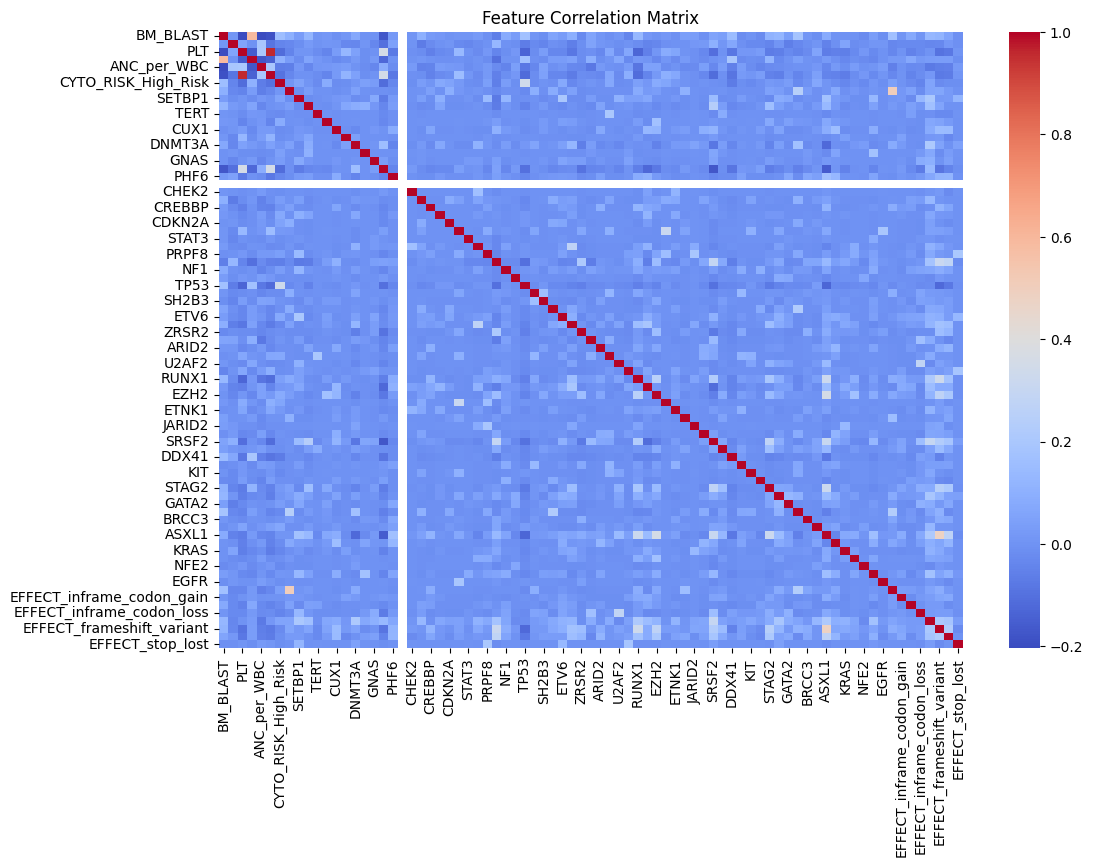

In [35]:
# DEBUGGING suggested by chatgpt quand on prend en compte les mutations data :

import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = X_train.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
# plt.show()

# TODO : ya bcp de correlation entre certains features!!!!! dans le petit carré en haut à gauche ----- faire de la feature selection


In [36]:
# define a threshold of correlation and print all the pairs of features that are highly correlated
threshold = 0.7
print(len(features))
for i in range(len(features)):
    for j in range(i+1, len(features)):
        if corr_matrix.iloc[i, j] > threshold:
            print(f"Features {features[i]} and {features[j]} are highly correlated with a correlation of {corr_matrix.iloc[i, j]:.2f}")

# print("3rd and sixth features are highly correlated")
# print(corr_matrix.iloc[2, 5])
# print("those features are :")
# print(features[2],"and", features[5])

79
Features PLT and PL_per_HB are highly correlated with a correlation of 0.96


In [37]:
# now that we have the pairs of highly correlated features, we can drop one of them
# Drop the highly correlated features
features.remove('PL_per_HB')

# update the training and testing sets
X_train = X_train.drop(columns=['PL_per_HB'])
X_test = X_test.drop(columns=['PL_per_HB'])

X = X.drop(columns=['PL_per_HB'])

print(len(features))


# recompute the correlation matrix
corr_matrix = X_train.corr()

78


In [42]:
# plt.figure(figsize=(12, 8))
# sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt=".2f")
# plt.title("Feature Correlation Matrix")

threshold = 0.7
print(len(features))
for i in range(len(features)):
    for j in range(i+1, len(features)):
        if corr_matrix.iloc[i, j] > threshold:
            print(f"Features {features[i]} and {features[j]} are highly correlated with a correlation of {corr_matrix.iloc[i, j]:.2f}")

78


### Step 5: Naive Approach to Incorporate Mutations

In this step, we take a very naive approach to account for genetic mutations by simply counting the total number of somatic mutations per patient. Instead of analyzing specific mutations or their biological impact, we use this aggregate count as a basic feature to reflect the mutational burden for each individual. Although simplistic, this feature can serve as a general indicator of genetic variability across patients, which may influence survival outcomes. More sophisticated mutation analysis could be incorporated in future models to improve predictive power.


In [43]:
# Step: Extract the number of somatic mutations per patient
# Group by 'ID' and count the number of mutations (rows) per patient
tmp = maf_df.groupby('ID').size().reset_index(name='Nmut')

# Merge with the training dataset and replace missing values in 'Nmut' with 0
df_2 = df.merge(tmp, on='ID', how='left').fillna({'Nmut': 0})

In [44]:
# Select features
# features = ['BM_BLAST', 'HB', 'PLT', 'Nmut']
# features = ['BM_BLAST', 'HB', 'PLT', 'WBC', 'ANC', 'MONOCYTES', 'Nmut']
# features = features_basic + ['BLAST_per_WBC', 'ANC_per_WBC', 'PL_per_HB', 'Nmut']
# features = features_basic + ['Nmut']
features = features + ['Nmut']
target = ['OS_YEARS', 'OS_STATUS']

# Create the survival data format
X = df_2.loc[df_2['ID'].isin(target_df['ID']), features]
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

In [45]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# TODO : change the random state?

In [46]:
# Survival-aware imputation for missing values
imputer = SimpleImputer(strategy="median")
X_train[features] = imputer.fit_transform(X_train[features])
X_test[features] = imputer.transform(X_test[features])

In [47]:
print("the features are:", features)
print("the number of features:", len(features))

the features are: ['BM_BLAST', 'HB', 'PLT', 'BLAST_per_WBC', 'ANC_per_WBC', 'CYTO_RISK_High_Risk', 'FLT3', 'SETBP1', 'IDH2', 'TERT', 'BRAF', 'CUX1', 'CALR', 'DNMT3A', 'SMC3', 'GNAS', 'SF3B1', 'PHF6', 'NOTCH1', 'CHEK2', 'PTPN11', 'CREBBP', 'CSF3R', 'CDKN2A', 'SUZ12', 'STAT3', 'BCORL1', 'PRPF8', 'TET2', 'NF1', 'IRF1', 'TP53', 'KDM6A', 'SH2B3', 'WT1', 'ETV6', 'BCOR', 'ZRSR2', 'IDH1', 'ARID2', 'GNB1', 'U2AF2', 'MPL', 'RUNX1', 'U2AF1', 'EZH2', 'MLL', 'ETNK1', 'PPM1D', 'JARID2', 'CTCF', 'SRSF2', 'CEBPA', 'DDX41', 'RAD21', 'KIT', 'CSNK1A1', 'STAG2', 'NRAS', 'GATA2', 'NPM1', 'BRCC3', 'JAK2', 'ASXL1', 'ASXL2', 'KRAS', 'SMC1A', 'NFE2', 'CBL', 'EGFR', 'EFFECT_ITD', 'EFFECT_inframe_codon_gain', 'EFFECT_PTD', 'EFFECT_inframe_codon_loss', 'EFFECT_non_synonymous_codon', 'EFFECT_frameshift_variant', 'EFFECT_stop_gained', 'EFFECT_stop_lost', 'Nmut']
the number of features: 79


In [48]:
# Initialize and train the Cox Proportional Hazards model
# cox = CoxPHSurvivalAnalysis()
cox = CoxPHSurvivalAnalysis(alpha=10.)
# TODO : ajuster les hyperparamètres
cox.fit(X_train, y_train)

# Evaluate the model using Concordance Index IPCW
cox_cindex_train = concordance_index_ipcw(y_train, y_train, cox.predict(X_train), tau=7)[0]
cox_cindex_test = concordance_index_ipcw(y_train, y_test, cox.predict(X_test), tau=7)[0]
print(f"Cox Proportional Hazard Model Concordance Index IPCW on train: {cox_cindex_train:.2f}")
print(f"Cox Proportional Hazard Model Concordance Index IPCW on test: {cox_cindex_test:.2f}")

Cox Proportional Hazard Model Concordance Index IPCW on train: 0.71
Cox Proportional Hazard Model Concordance Index IPCW on test: 0.70


### Step 6 : Random Survival Forest model 

In [ ]:
# # Selecting the adequate features for the Random Survival Forest model
# features = features_basic + features_additional + features_cytogenetics + ['Nmut']
# or just using all the features

# # Survival-aware imputation for missing values
# imputer = SimpleImputer(strategy="median")
# X_train[features] = imputer.fit_transform(X_train[features])
# X_test[features] = imputer.transform(X_test[features])

In [49]:
# Initialize and train Random Survival Forest
rsf = RandomSurvivalForest(n_estimators=200, min_samples_split=10, min_samples_leaf=5, max_depth=5, random_state=42)
rsf.fit(X_train, y_train)

# Evaluate using IPCW Concordance Index
rsf_cindex_train = concordance_index_ipcw(y_train, y_train, rsf.predict(X_train), tau=7)[0]
rsf_cindex_test = concordance_index_ipcw(y_train, y_test, rsf.predict(X_test), tau=7)[0]

print(f"RSF Concordance Index IPCW on train: {rsf_cindex_train:.2f}")
print(f"RSF Concordance Index IPCW on test: {rsf_cindex_test:.2f}")

RSF Concordance Index IPCW on train: 0.74
RSF Concordance Index IPCW on test: 0.71


In [ ]:
# Training for a different horizon : TAU = 5 years

# Initialize and train Random Survival Forest
rsf2 = RandomSurvivalForest(n_estimators=200, min_samples_split=10, min_samples_leaf=5, max_depth=5, random_state=42)
rsf2.fit(X_train, y_train)

# Evaluate using IPCW Concordance Index
rsf2_cindex_train = concordance_index_ipcw(y_train, y_train, rsf2.predict(X_train), tau=5)[0]
rsf2_cindex_test = concordance_index_ipcw(y_train, y_test, rsf2.predict(X_test), tau=5)[0]

print(f"RSF Concordance Index IPCW on train: {rsf2_cindex_train:.2f}")
print(f"RSF Concordance Index IPCW on test: {rsf2_cindex_test:.2f}")

RSF Concordance Index IPCW on train: 0.75
RSF Concordance Index IPCW on test: 0.72


In [ ]:
# # Best parameters found: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
# # Initialize and train Random Survival Forest
# wow = RandomSurvivalForest(n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_depth=3, random_state=42)
# wow.fit(X_train, y_train)

# # Evaluate using IPCW Concordance Index
# wow_cindex_train = concordance_index_ipcw(y_train, y_train, wow.predict(X_train), tau=7)[0]
# wow_cindex_test = concordance_index_ipcw(y_train, y_test, wow.predict(X_test), tau=7)[0]

# print(f"RSF Concordance Index IPCW on train: {wow_cindex_train:.2f}")
# print(f"RSF Concordance Index IPCW on test: {wow_cindex_test:.2f}")

RSF Concordance Index IPCW on train: 0.72
RSF Concordance Index IPCW on test: 0.70


In [34]:
print(len(features))
# TODO : maybe mix long and short term predictions?

80


In [48]:
# TODO : cross validation?

In [44]:
# Grid search for the best hyperparameters
from sklearn.model_selection import GridSearchCV
# Define the parameter grid for the Random Survival Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

# Initialize the Random Survival Forest model
rsf = RandomSurvivalForest(random_state=42)

# Initialize GridSearchCV with the RSF model and parameter grid
grid_search = GridSearchCV(estimator=rsf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters found: {best_params}")
print(f"Best score found: {best_score}")

# TODO : faire un grid search pour toutes les méthodes


c:\Users\Nour\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best parameters found: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score found: nan


*****************
### Inference on test set

In [50]:
tmp_eval = maf_eval.groupby('ID').size().reset_index(name='Nmut')

# Merge with the training dataset and replace missing values in 'Nmut' with 0
df_eval = df_eval.merge(tmp_eval, on='ID', how='left').fillna({'Nmut': 0})

df_eval.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,BLAST_per_WBC,ANC_per_WBC,...,EGFR,EFFECT_ITD,EFFECT_inframe_codon_gain,EFFECT_PTD,EFFECT_inframe_codon_loss,EFFECT_non_synonymous_codon,EFFECT_frameshift_variant,EFFECT_stop_gained,EFFECT_stop_lost,Nmut
0,KYW1,KYW,68.0,3.45,0.5865,0.0,7.6,48.0,19.710145,0.17,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,4.0
1,KYW2,KYW,35.0,3.18,1.2402,0.0,10.0,32.0,11.006289,0.39,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0
2,KYW3,KYW,0.0,12.40,8.6800,0.0,12.3,25.0,0.000000,0.70,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,3.0
3,KYW4,KYW,61.0,5.55,2.0535,0.0,8.0,44.0,10.990991,0.37,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0
4,KYW5,KYW,2.0,1.21,0.7381,0.0,8.6,27.0,1.652893,0.61,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,3.0


In [37]:
# df_eval.drop(columns="Nmut_x", inplace=True)    
# df_eval.rename(columns={"Nmut_y": "Nmut"}, inplace=True)
# df_eval.head()

In [51]:
# Display the features we have selected
# print(features)
# df_eval.head()
df_eval[features] = imputer.transform(df_eval[features])
cox_prediction_on_test_set = cox.predict(df_eval.loc[:, features])

In [52]:
# df_eval[features] = imputer.transform(df_eval[features])
rsf_prediction_on_test_set = rsf.predict(df_eval.loc[:, features])
# lgb_prediction_on_test_set = model.predict(df_eval.loc[:, features])

#### Saving the submission

In [46]:
# submission = pd.Series(prediction_on_test_set, index=df_eval['ID'], name='OS_YEARS')
cox_test_submission = pd.Series(cox_prediction_on_test_set, index=df_eval['ID'], name='risk_score')
rsf_test_submission = pd.Series(rsf_prediction_on_test_set, index=df_eval['ID'], name='risk_score')

In [62]:
submission

ID
KYW1       642.916408
KYW2       625.347556
KYW3       355.776220
KYW4       690.475762
KYW5       560.101718
              ...    
KYW1189    384.186803
KYW1190    400.289687
KYW1191    316.310636
KYW1192    420.195475
KYW1193    837.647525
Name: risk_score, Length: 1193, dtype: float64

In [ ]:
import datetime

os.makedirs('./output', exist_ok=True)

# I just want the date and hour and minute
now = datetime.datetime.now()
now = now.strftime("%Y-%m-%d_%H-%M")

# submission.to_csv(f'./output/submission_{now}_rsf_ok.csv')
cox_test_submission.to_csv(f'./output/submission_{now}_cox.csv')
rsf_test_submission.to_csv(f'./output/submission_{now}_rsf.csv')
# submission.to_csv('./output/all_clinical_features_submission.csv')

In [50]:
# submission
# cox_test_submission

In [61]:
import datetime
def now_str():
    now = datetime.datetime.now()
    return now.strftime("%Y-%m-%d_%H-%M")

***************
### Stacking a meta model

In [65]:
from sklearn.linear_model import LogisticRegression

# Load test survival data
# rsf_preds = pd.read_csv("./output/submission_2025-03-10_00-29_rsf.csv", index_col="ID")  
# cox_preds = pd.read_csv("./output/submission_2025-03-10_00-29_cox.csv", index_col="ID")  

# Stack RSF & Cox risk scores
stacked_X_train = pd.DataFrame({"rsf_score": rsf.predict(X_train), "cox_score": cox.predict(X_train)}, index=X_train.index)
# stacked_X_test = pd.DataFrame({"rsf_score": rsf_preds["risk_score"], "cox_score": cox_preds["risk_score"]})
stacked_X_test = pd.DataFrame({"rsf_score": rsf.predict(X_test), "cox_score": cox.predict(X_test)}, index=X_test.index)

# Ensure that y_train and stacked_X_train have the same shape
# assert stacked_X_train.shape[0] == y_train.shape[0], "Mismatched train data sizes!"

# Train a meta-learner
meta_model = LogisticRegression()
meta_model.fit(stacked_X_train, y_train)

# Predict combined survival scores
ensemble_preds = meta_model.predict_proba(stacked_X_test)[:, 1]

# print(f"y_train shape: {y_train.shape}")
# print(f"y_test shape: {y_test.shape}")
# print(f"ensemble_preds shape: {ensemble_preds.shape}")

# Evaluate IPCW C-index
ensemble_cindex = concordance_index_ipcw(y_train, y_test, ensemble_preds, tau=7)[0]
print(f"Meta-Learner IPCW C-index: {ensemble_cindex}")

Meta-Learner IPCW C-index: 0.6806737083381084


c:\Users\Nour\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [54]:
print(y_train.shape)
# print(y_train[:,0])

(2221,)


In [ ]:
# TODO : Z norm maybe before applying the meta model?

In [ ]:
# TODO : feature selection

In [57]:
import xgboost as xgb
from sksurv.metrics import concordance_index_ipcw

# Stack RSF & Cox risk scores
stacked_X_train = pd.DataFrame({"rsf_score": rsf.predict(X_train), "cox_score": cox.predict(X_train)}, index=X_train.index)
stacked_X_test = pd.DataFrame({"rsf_score": rsf.predict(X_test), "cox_score": cox.predict(X_test)}, index=X_test.index)

# Convert survival labels to a format usable by XGBoost (duration and event)
y_train_event = y_train["OS_STATUS"].astype(int)  # 1 if event occurred, 0 otherwise
y_train_time = y_train["OS_YEARS"]  # Survival time

# Train an XGBoost model for survival ranking
dtrain = xgb.DMatrix(stacked_X_train, label=y_train_time)  # Use time as label for ranking
dtest = xgb.DMatrix(stacked_X_test)

params = {
    "objective": "rank:pairwise",  # Optimized for ranking risk scores
    "eval_metric": "ndcg",  # Normalized Discounted Cumulative Gain
    "eta": 0.05,  # Learning rate
    "max_depth": 3,  # Small depth to avoid overfitting
    "subsample": 0.8,  # Use 80% of data per tree
    "colsample_bytree": 0.8,  # Use 80% of features per tree
}

xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Predict survival risk scores
train_ensemble_preds = -xgb_model.predict(dtrain)
ensemble_preds = -xgb_model.predict(dtest)

# Evaluate IPCW C-index
# train ipcw c-index
ensemble_cindex_train = concordance_index_ipcw(y_train, y_train, train_ensemble_preds, tau=7)[0]
# test ipcw c-index
ensemble_cindex = concordance_index_ipcw(y_train, y_test, ensemble_preds, tau=7)[0]
print(f"Optimized Meta-Learner IPCW C-index on train: {ensemble_cindex_train}")
print(f"Optimized Meta-Learner IPCW C-index on test : {ensemble_cindex}")

Optimized Meta-Learner IPCW C-index on train: 0.7231725030578161
Optimized Meta-Learner IPCW C-index on test : 0.7013334695694249


In [68]:
print(stacked_X_train.corr())

           rsf_score  cox_score
rsf_score   1.000000   0.907199
cox_score   0.907199   1.000000


In [62]:
# Inference time

# Load test survival data
rsf_preds = pd.read_csv("./output/submission_2025-03-10_00-29_rsf.csv", index_col="ID")
cox_preds = pd.read_csv("./output/submission_2025-03-10_00-29_cox.csv", index_col="ID")  

# Stack RSF & Cox risk scores of the test set
stacked_inference = pd.DataFrame({"rsf_score": rsf_preds["risk_score"], "cox_score": cox_preds["risk_score"]})
dinference = xgb.DMatrix(stacked_inference)

# Predict survival risk scores
inference_preds = -xgb_model.predict(dinference)

# Save the submission file
submission = pd.Series(inference_preds, index=stacked_inference.index, name='risk_score')
submission
submission.to_csv(f'./output/submission_meta_xgboost_{now_str()}_ensemble.csv')

*******************
### Step 7 : try combining the 2 models' (COX, RSF) results :


In [60]:
# os.listdir('./output')

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# # Load RSF and Cox predictions
# rsf_preds = pd.read_csv("./output/submission_2025-03-07_23-11_rsf.csv", index_col="ID")  
# cox_preds = pd.read_csv("./output/submission_2025-03-07_20-34_cox.csv", index_col="ID")  

# # Step 1: Convert Cox risk scores to survival time estimates
# cox_preds["survival_time"] = np.exp(-cox_preds["risk_score"])  # Transforming risk scores
# # print(cox_preds.head())

# # Step 2: Normalize predictions (Min-Max Scaling)
# scaler = MinMaxScaler()

# rsf_preds["normalized"] = scaler.fit_transform(rsf_preds.iloc[:, 0].values.reshape(-1, 1))
# cox_preds["normalized"] = scaler.fit_transform(cox_preds["survival_time"].values.reshape(-1, 1))
# # print(rsf_preds.head())
# # print(cox_preds.head())

# # Step 3: Ensemble (Weighted Average)
# rsf_weight = 0.6  # Adjust based on validation set performance
# cox_weight = 0.4

# ensemble_preds = (rsf_weight * rsf_preds["normalized"]) + (cox_weight * cox_preds["normalized"])
# ensemble_preds = pd.DataFrame(ensemble_preds, columns=["normalized"], index=rsf_preds.index)
# ensemble_preds.index.name = "ID"
# # print(ensemble_preds.head())

# # # Save final predictions
# ensemble_preds.to_csv("./output/ensemble_predictions.csv")

# # print("Ensemble predictions saved successfully!")


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Load RSF and Cox predictions
rsf_preds = pd.read_csv("./output/submission_2025-03-07_23-11_rsf.csv", index_col="ID")  
cox_preds = pd.read_csv("./output/submission_2025-03-07_20-34_cox.csv", index_col="ID") 

# Step 1: Convert RSF survival time into risk scores
epsilon = 1e-6  # Small value to avoid division by zero
rsf_preds["risk_score"] = 1 / (rsf_preds.iloc[:, 0] + epsilon)

# Step 2: Normalize both RSF and Cox risk scores
scaler = MinMaxScaler()
rsf_preds["normalized"] = scaler.fit_transform(rsf_preds["risk_score"].values.reshape(-1, 1))
cox_preds["normalized"] = scaler.fit_transform(cox_preds["risk_score"].values.reshape(-1, 1))
# print(rsf_preds.head())
# print(cox_preds.head())

# Step 3: Ensemble (Weighted Average)
# rsf_weight = 0.5  # Adjust based on validation set performance
# cox_weight = 0.5
# Assign weights based on IPCW C-index
rsf_weight = rsf_cindex_test / (rsf_cindex_test + cox_cindex_test)
cox_weight = cox_cindex_test / (rsf_cindex_test + cox_cindex_test)

print(f"Optimized Weights -> RSF: {rsf_weight:.3f}, Cox: {cox_weight:.3f}")


ensemble_risk_scores = (rsf_weight * rsf_preds["normalized"]) + (cox_weight * cox_preds["normalized"])
# format the ensemble risk scores to be a csv with the ID as the index, and the risk score as the only column
ensemble_risk_scores = pd.DataFrame(ensemble_risk_scores, columns=["normalized"], index=rsf_preds.index)
ensemble_risk_scores.index.name = "ID"
# rename the column to "risk_score"
ensemble_risk_scores.rename(columns={"normalized": "risk_score"}, inplace=True)
print(ensemble_risk_scores.head())


# Save final predictions
# ensemble_risk_scores.to_csv("ensemble_risk_scores.csv")

print("Ensemble risk scores saved successfully!")


Optimized Weights -> RSF: 0.500, Cox: 0.500
      risk_score
ID              
KYW1    0.418289
KYW2    0.369236
KYW3    0.452954
KYW4    0.391498
KYW5    0.379527
Ensemble risk scores saved successfully!


In [ ]:
# TODO : test chaque methode seule deja sur la platforme
# - test les resultats de RSF, mais need to be formatted before

In [93]:
# # Trying to fix the ensemble issue :

# from sklearn.preprocessing import MinMaxScaler
# from scipy.stats import rankdata

# # Load RSF and Cox predictions
# rsf_preds = pd.read_csv("./output/submission_2025-03-07_23-11_rsf.csv", index_col="ID")  
# cox_preds = pd.read_csv("./output/submission_2025-03-07_20-34_cox.csv", index_col="ID") 

# # Step 1: Convert RSF survival time into risk scores
# epsilon = 1e-6  # Avoid division by zero
# rsf_preds["risk_score"] = 1 / (rsf_preds.iloc[:, 0] + epsilon)  # Inverting survival time

# # Step 2: Compute IPCW C-index for both models
# # Step 3: Assign weights dynamically
# rsf_weight = rsf_cindex_test / (rsf_cindex_test + cox_cindex_test)
# cox_weight = cox_cindex_test / (rsf_cindex_test + cox_cindex_test)

# print(f"Optimized Weights -> RSF: {rsf_weight:.3f}, Cox: {cox_weight:.3f}")

# # Step 4: Normalize using Rank Transformation
# rsf_preds["ranked"] = rankdata(rsf_preds["risk_score"]) / len(rsf_preds)
# cox_preds["ranked"] = rankdata(cox_preds["risk_score"]) / len(cox_preds)

# # Step 5: Compute Weighted Ensemble
# ensemble_risk_scores = (rsf_weight * rsf_preds["ranked"]) + (cox_weight * cox_preds["ranked"])
# # print(ensemble_risk_scores)

# # Convert back to original scale if needed (optional)
# ensemble_risk_scores = pd.DataFrame(ensemble_risk_scores, columns=["ranked"], index=rsf_preds.index)
# ensemble_risk_scores.index.name = "ID"
# ensemble_risk_scores.rename(columns={"ranked": "risk_score"}, inplace=True)
# print(ensemble_risk_scores.head())

# # Save final predictions in correct format
# ensemble_risk_scores.to_csv("ensemble_risk_scores_reranked.csv")

# print("Final ensemble predictions saved with corrected risk alignment and weights!")


In [ ]:
# try to combine, COX and RSF model : classic linear averaging
from sklearn.preprocessing import MinMaxScaler

# Load RSF and Cox predictions
rsf_preds = pd.read_csv("./output/submission_2025-03-08_23-44_rsf_ok.csv", index_col="ID")  
cox_preds = pd.read_csv("./output/submission_2025-03-07_20-34_cox.csv", index_col="ID") 

# # Step 1: Convert RSF survival time into risk scores
# epsilon = 1e-6  # Small value to avoid division by zero
# rsf_preds["risk_score"] = 1 / (rsf_preds.iloc[:, 0] + epsilon)

# I want to scale the rsf_preds["risk_score"] to be between the minimum and maximum value of cox_preds
# Step 2: Normalize RSF risk scores to the range of Cox risk scores
min_cox = cox_preds["risk_score"].min()
max_cox = cox_preds["risk_score"].max()

scaler = MinMaxScaler(feature_range=(min_cox, max_cox))
rsf_preds["scaled_risk_score"] = scaler.fit_transform(rsf_preds[["risk_score"]])

# Step 3: Combine the normalized RSF and Cox risk scores (e.g., averaging)
combined_risk_score = (rsf_preds["scaled_risk_score"] + cox_preds["risk_score"]) / 2

# Store final risk scores
final_preds = pd.DataFrame({"ID": rsf_preds.index, "risk_score": combined_risk_score})

# Save to CSV
# final_preds.to_csv("./output/combined_risk_scores.csv", index=False)
# final_preds



In [7]:
# TRYING A NEW STRATEGY TO COMBINE BOTH RESULTS :
import datetime

os.makedirs('./output', exist_ok=True)

# I just want the date and hour and minute
now = datetime.datetime.now()
now = now.strftime("%Y-%m-%d_%H-%M")

# Load RSF and Cox predictions
rsf_preds = pd.read_csv("./output/submission_2025-03-08_23-44_rsf_ok.csv", index_col="ID")  
cox_preds = pd.read_csv("./output/submission_2025-03-07_20-34_cox.csv", index_col="ID")

# Standardize RSF and Cox risk scores
rsf_preds["z_score"] = (rsf_preds["risk_score"] - rsf_preds["risk_score"].mean()) / rsf_preds["risk_score"].std()
cox_preds["z_score"] = (cox_preds["risk_score"] - cox_preds["risk_score"].mean()) / cox_preds["risk_score"].std()

# Define weights based on performance
w_rsf = 0.745 / (0.745 + 0.72)  # Weight proportional to C-index
w_cox = 0.72 / (0.745 + 0.72)

# Weighted combination using z-scores
combined_risk_score = (w_rsf * rsf_preds["z_score"] + w_cox * cox_preds["z_score"])

# Store final risk scores
final_preds = pd.DataFrame({"ID": rsf_preds.index, "risk_score": combined_risk_score})
final_preds.to_csv(f"./output/combined_risk_scores_zscore_{now}.csv", index=False)

***************
### Trying a DeepLearning model

In [92]:
from pycox.models import CoxPH
import torch
from torchtuples.practical import MLPVanilla

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert data to tensors
X_train_t = torch.tensor(X_train.values, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test.values, dtype=torch.float32).to(device)

# Define a simple MLP model
net = MLPVanilla(in_features=X_train.shape[1], num_nodes=[64, 32], out_features=1, batch_norm=True, dropout=0.1, output_bias=False).to(device)
# print(y_train.dtype)

y_train["OS_STATUS"] = y_train["OS_STATUS"].astype(int)
y_train["OS_YEARS"] = y_train["OS_YEARS"].astype(float)

# Train DeepSurv
model = CoxPH(net)
model.fit(X_train_t, y_train, batch_size=128, epochs=200, verbose=True)

# Predict risk scores
deep_risk_scores = -model.predict(X_test_t).cpu().detach().numpy()

# Evaluate
deep_cindex = concordance_index_ipcw(y_train, y_test, deep_risk_scores, tau=7)[0]
print(f"DeepSurv IPCW C-index: {deep_cindex}")


ValueError: All objects in 'data' doest have the same type.